# Exploratory Analysis: Powerball & Mega Millions

This notebook explores historical Powerball and Mega Millions draw data.
The goal is to validate data quality, examine number frequencies,
and identify patterns that may appear in random systems.

## 1. Data Loading & Schema Validation

We begin by loading the canonical draw datasets for Powerball and Mega Millions
and validating that both sources conform to a shared schema.

In [22]:
import json
from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import chisquare
import numpy as np

plt.style.use("ggplot")
Data_dir = Path("../data/raw")
pb = json.loads((Data_dir / "powerball_draws.json").read_text())
mm = json.loads((Data_dir / "megamillions_draws.json").read_text())

df_pb = pd.DataFrame(pb)
df_mm = pd.DataFrame(mm)





## 2. Dataset Coverage Overview

Before analyzing distributions, we verify the number of draws and
date ranges covered for each lottery game.

In [23]:
df = pd.concat([df_pb, df_mm], ignore_index = True)
df["draw_date"] = pd.to_datetime(df["draw_date"], format="mixed", errors="coerce")
df["draw_date"].isna().sum(), df.shape
df[df["draw_date"].isna()][["game", "draw_date"]].head(10)

df.groupby("game").agg(
    draws=("draw_date", "count"),
    start_date=("draw_date", "min"),
    end_date=("draw_date", "max"),
)

,draws,start_date,end_date
game,,,
megamillions,2000,2006-10-17,2025-12-23
powerball,1000,2018-07-18,2025-12-24


## 3. White Ball Frequency Analysis (All-Time)

To understand long-run behavior, we analyze how frequently each white ball
number has appeared across the full historical dataset.

In [24]:
white_long = (
    df
    .explode("white_numbers")
    .rename(columns={"white_numbers": "white_ball"})
)

freq = (
    white_long
    .groupby(["game", "white_ball"])
    .size()
    .reset_index(name="count")
)

freq.head()


,game,white_ball,count
0,megamillions,1,139
1,megamillions,2,169
2,megamillions,3,171
3,megamillions,4,163
4,megamillions,5,145


<function matplotlib.pyplot.show(close=None, block=None)>

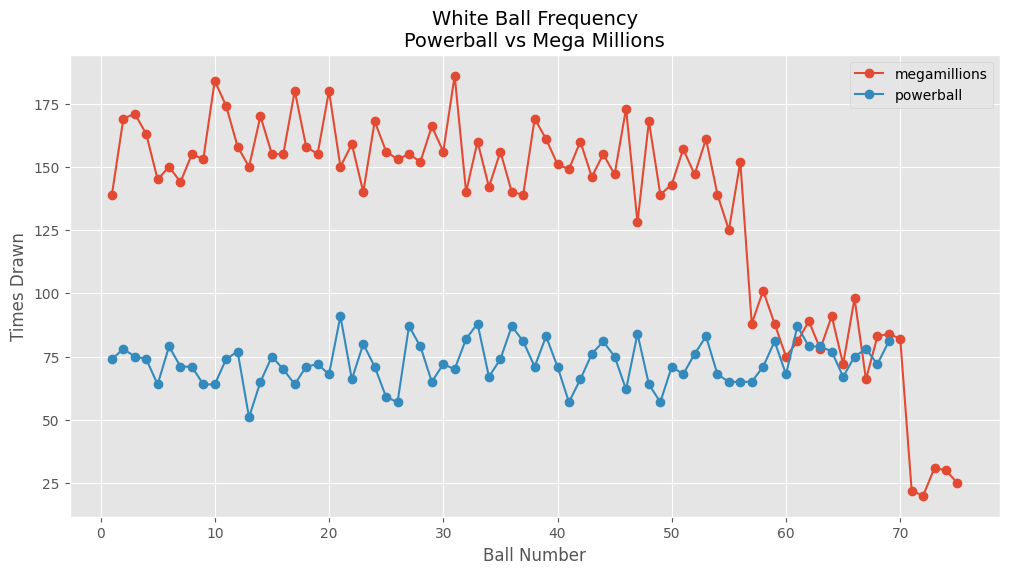

In [25]:
fig, ax = plt.subplots(figsize=(12, 6))

for game, gdf in freq.groupby("game"):
    ax.plot(
        gdf["white_ball"],
        gdf["count"],
        marker="o",
        label=game
    )

ax.set_title("White Ball Frequency\nPowerball vs Mega Millions", fontsize=14)
ax.set_xlabel("Ball Number")
ax.set_ylabel("Times Drawn")
ax.legend()
plt.show

## 4. Bonus Ball Frequency Analysis

In addition to white balls, we examine the frequency distribution
of bonus balls (Powerball and Mega Ball).

In [26]:
bonus_freq = (
    df
    .groupby(["game", "bonus_ball"])
    .size()
    .reset_index(name="count")
)

bonus_freq.head()


,game,bonus_ball,count
0,megamillions,1,78
1,megamillions,2,72
2,megamillions,3,79
3,megamillions,4,74
4,megamillions,5,59


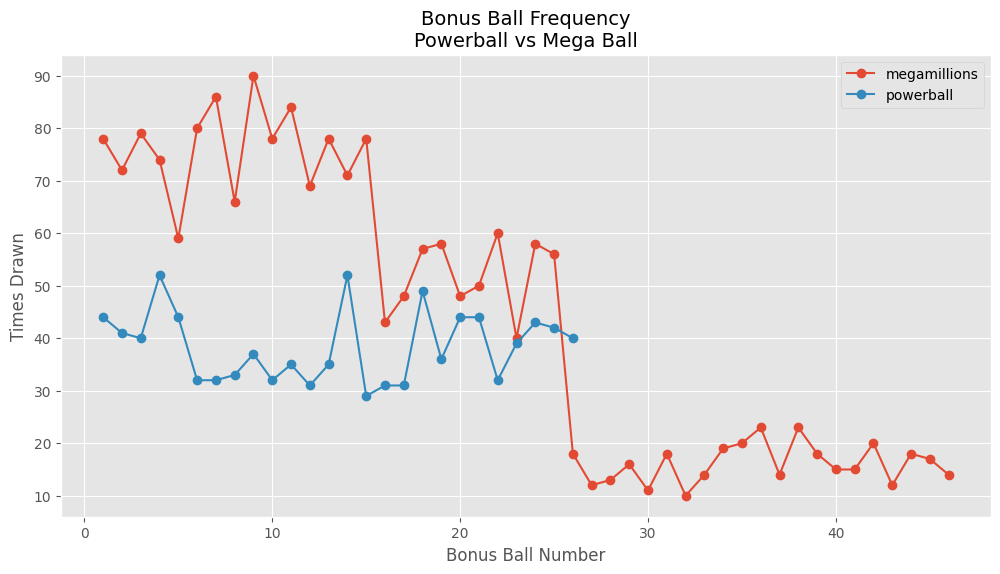

In [27]:
fig, ax = plt.subplots(figsize=(12, 6))

for game, gdf in bonus_freq.groupby("game"):
    ax.plot(
        gdf["bonus_ball"],
        gdf["count"],
        marker="o",
        label=game
    )

ax.set_title("Bonus Ball Frequency\nPowerball vs Mega Ball", fontsize=14)
ax.set_xlabel("Bonus Ball Number")
ax.set_ylabel("Times Drawn")
ax.legend()
plt.show()


## 5. Short-Term vs Long-Term Comparison (Hot vs Cold)

To explore the perception of "hot" and "cold" numbers, we compare
recent draw frequencies against long-run historical frequencies.

In [28]:
recent_n = 50

#split recent vs all - time
recent_df = (
    df
    .sort_values("draw_date")
    .groupby("game")
    .tail(recent_n)
)

recent_white = (
    recent_df
    .explode("white_numbers")
    .rename(columns={"white_numbers": "white_ball"})
)

all_white = white_long.copy()
recent_white.head(), all_white.head()

(              game  draw_date white_ball  bonus_ball multiplier       source  \
 1049  megamillions 2025-07-04         17          24       None  data.ny.gov   
 1049  megamillions 2025-07-04         20          24       None  data.ny.gov   
 1049  megamillions 2025-07-04         24          24       None  data.ny.gov   
 1049  megamillions 2025-07-04         41          24       None  data.ny.gov   
 1049  megamillions 2025-07-04         42          24       None  data.ny.gov   
 
                            ingested_at  
 1049  2025-12-26T08:03:42.449460+00:00  
 1049  2025-12-26T08:03:42.449460+00:00  
 1049  2025-12-26T08:03:42.449460+00:00  
 1049  2025-12-26T08:03:42.449460+00:00  
 1049  2025-12-26T08:03:42.449460+00:00  ,
         game  draw_date white_ball  bonus_ball multiplier       source  \
 0  powerball 2025-12-24          4          19          2  data.ny.gov   
 0  powerball 2025-12-24         25          19          2  data.ny.gov   
 0  powerball 2025-12-24         3

Compute frequencies (recent vs all time)

In [29]:
recent_freq = (
    recent_white
    .groupby(["game", "white_ball"])
    .size()
    .reset_index(name="recent_count")
)

all_freq = (
    all_white
    .groupby(["game", "white_ball"])
    .size()
    .reset_index(name="alltime_count")
)

freq_compare = recent_freq.merge(
    all_freq,
    on = ["game", "white_ball"],
    how = "left"
)

freq_compare.head()

,game,white_ball,recent_count,alltime_count
0,megamillions,1,3,139
1,megamillions,2,5,169
2,megamillions,3,2,171
3,megamillions,4,5,163
4,megamillions,5,1,145


Normalize for fair comparison

In [30]:
freq_compare["recent_rate"] = freq_compare["recent_count"]/ recent_n
freq_compare["alltime_count"] = (
    freq_compare
    .groupby("game")["alltime_count"]
    .transform(lambda x: x / x.sum())
)

freq_compare.head()

,game,white_ball,recent_count,alltime_count,recent_rate
0,megamillions,1,3,0.014491,0.06
1,megamillions,2,5,0.017619,0.10
2,megamillions,3,2,0.017827,0.04
3,megamillions,4,5,0.016993,0.10
4,megamillions,5,1,0.015117,0.02


Plot Hot vs Cold

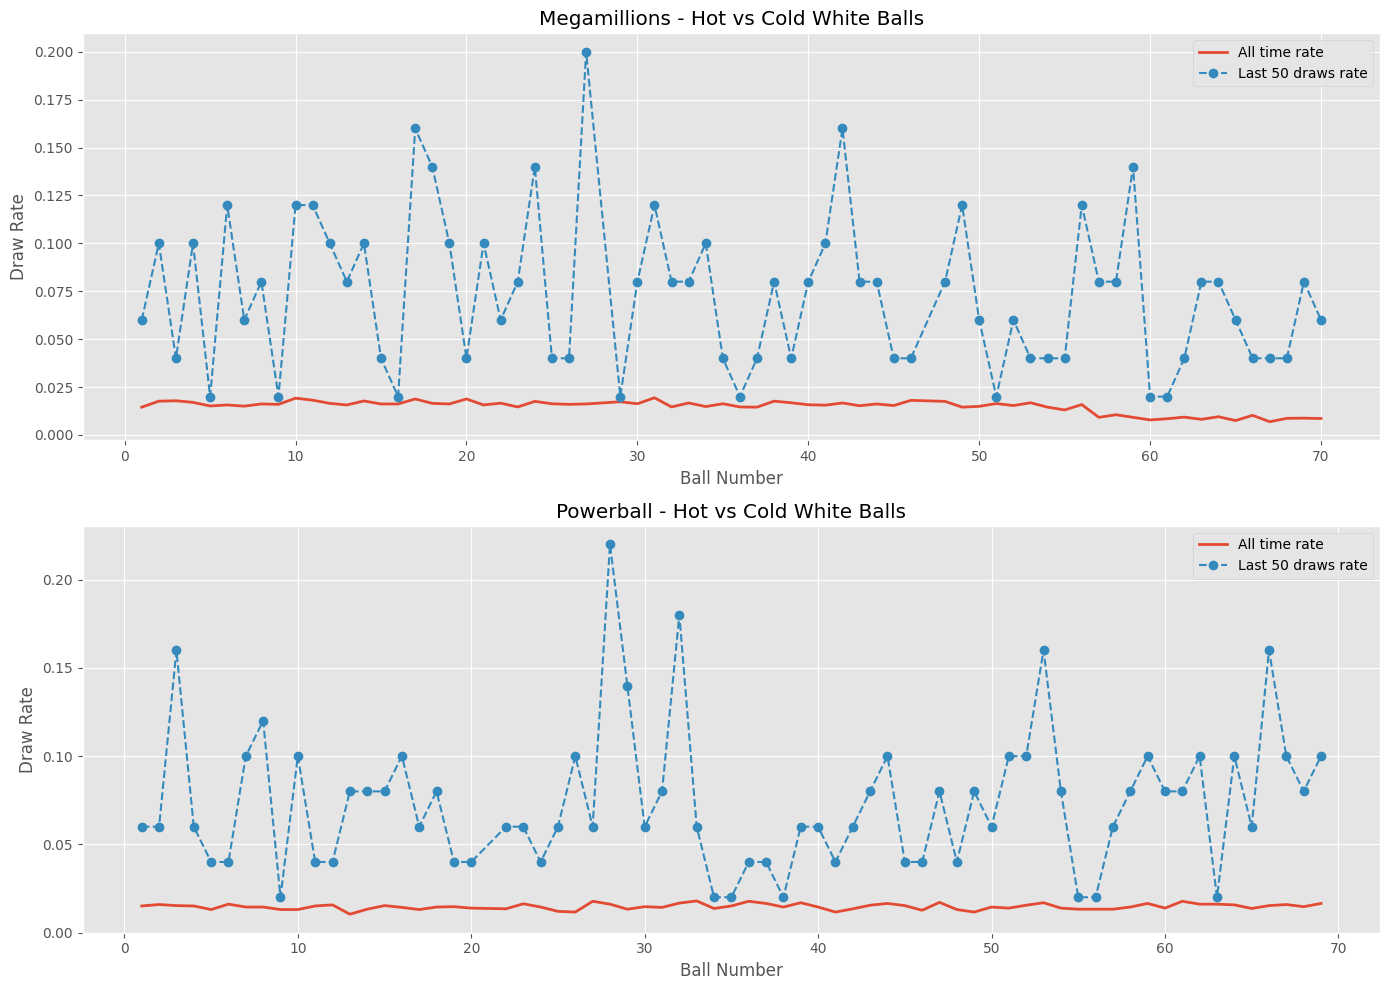

In [31]:
fig, axes = plt.subplots(2,1,figsize=(14,10), sharex=False)

for ax, game in zip(axes, freq_compare["game"].unique()):
    gdf = freq_compare[freq_compare["game"] == game]

    ax.plot(
        gdf["white_ball"],
        gdf["alltime_count"],
        label = "All time rate",
        linewidth = 2
    )

    ax.plot(
        gdf["white_ball"],
        gdf["recent_rate"],
        label=f"Last {recent_n} draws rate",
        linestyle = "--",
        marker = "o"
    )

    ax.set_title(f"{game.capitalize()} - Hot vs Cold White Balls")
    ax.set_xlabel("Ball Number")
    ax.set_ylabel("Draw Rate")
    ax.legend()

plt.tight_layout()
plt.show()

## 6. Statistical Testing: Chi-Square Goodness of Fit

To formally evaluate whether observed frequency deviations are consistent
with randomness, we apply a chi-square goodness-of-fit test.

In [32]:

observed = (
    white_long
    .groupby(["game", "white_ball"])
    .size()
    .reset_index(name = "observed")
)

observed.head()



,game,white_ball,observed
0,megamillions,1,139
1,megamillions,2,169
2,megamillions,3,171
3,megamillions,4,163
4,megamillions,5,145


In [33]:
ball_range = {
    "powerball" : 69,
    "megamillions" : 70
}

results = {}

for game in ["powerball", "megamillions"]:
    max_ball = ball_range[game]

    full = pd.DataFrame({"white_ball": range(1, max_ball + 1)})
    game_df = observed[observed["game"] == game][["white_ball", "observed"]]
    game_full = full.merge(game_df, on="white_ball", how="left").fillna({"observed": 0})

    obs = game_full["observed"].to_numpy()

    # Expected: uniform distribution across all balls
    total = obs.sum()
    exp = np.full_like(obs, fill_value=total / max_ball, dtype=float)

    chi2, p_value = chisquare(f_obs=obs, f_exp=exp)

    results[game] = {
        "chi_square": float(chi2),
        "p_value": float(p_value),
        "degrees_of_freedom": int(max_ball - 1),
        "total_white_balls": int(total),
    }

results

{'powerball': {'chi_square': 64.9312,
  'p_value': 0.583084267350578,
  'degrees_of_freedom': 68,
  'total_white_balls': 5000},
 'megamillions': {'chi_square': 479.47690437601295,
  'p_value': 9.253954487556818e-63,
  'degrees_of_freedom': 69,
  'total_white_balls': 9872}}